In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
database_path = "hawaii_db"
conn = engine.connect()
Base = automap_base()

# reflect the tables
Base.metadata.create_all(engine)
Base.prepare(engine, reflect=True)

C:\Users\katro\AppData\Local\Temp\ipykernel_29168\3966766292.py:8: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [12]:
# View all of the classes that automap found
for class_name in Base.classes.keys(): 
    print(class_name)

measurement
station


In [13]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [20]:
# Find the most recent date in the data set.
from sqlalchemy import desc
recent_date = session.query(measurement).order_by(desc(measurement.date)).first()
print(recent_date.date)

2017-08-23


Most Recent Date: 2017-08-23 00:00:00
Past 12 Months: 2016-08-23 00:00:00


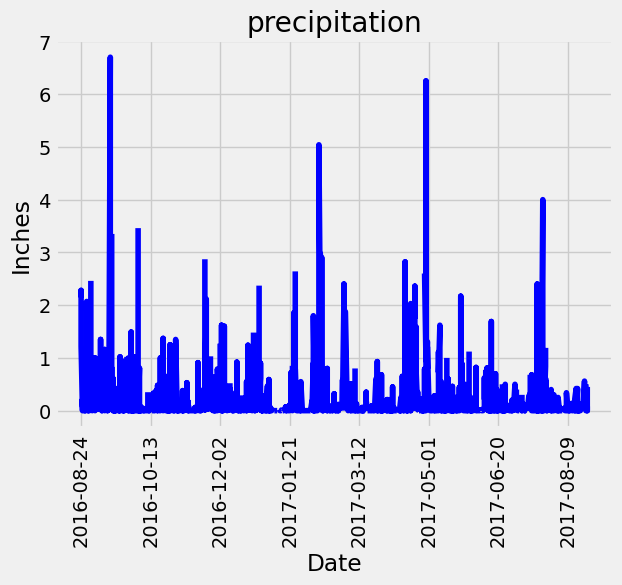

In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
from datetime import datetime, timedelta
start_date = datetime.strptime(recent_date.date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
last_year = start_date - timedelta(days=365)

print("Most Recent Date:", start_date) 
print("Past 12 Months:", last_year)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df= pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
prcp_df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(prcp_df['date'], prcp_df['precipitation'], color='b')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(9))
plt.xticks(rotation=90)
plt.grid(True)
plt.title('precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

Text(0, 0.5, 'Inches')

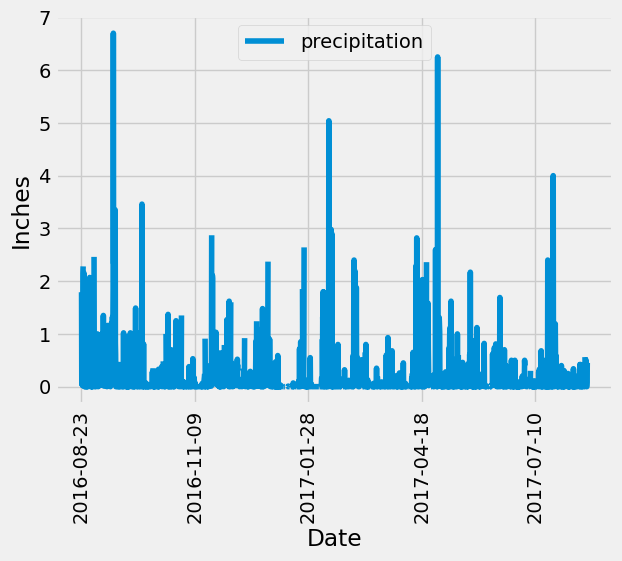

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
start_date = recent_date.date

# Calculate the date one year from the last date in data set.
last_year = 

# Perform a query to retrieve the data and precipitation scores
query = text("SELECT * FROM your_table WHERE date = :start_date") 
result = session.execute(query, {"date": start_date}) 

for row in result:
    print(row)

# Save the query results as a Pandas DataFrame. Explicitly set the column names


# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data

# Plot the results (optional)
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['precipitation'], marker='o', linestyle='-', color='b')
plt.title('Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [54]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_df['precipitation'].describe()
print(summary_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


In [ ]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_df['precipitation'].describe()
print(summary_stats)

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset


[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 4.183333333333314, 'Temperature')

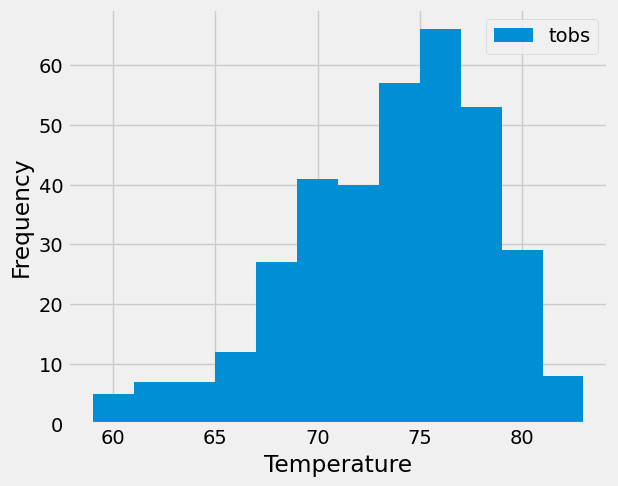

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [16]:
# Close Session
session.close()